# Introducción a la Ciencia de Datos: Tarea 2

Este notebook contiene el código de base para realizar la Tarea 2 del curso. Puede copiarlo en su propio repositorio y trabajar sobre el mismo.
Las **instrucciones para ejecutar el notebook** están en la [página inicial del repositorio](https://gitlab.fing.edu.uy/maestria-cdaa/intro-cd/).

**Se espera que no sea necesario revisar el código para corregir la tarea**, ya que todos los resultados y análisis relevantes deberían estar en el **informe en formato PDF**.

## Cargar dependencias
Para esta tarea, se han agregado algunos requerimientos, asegúrese de instalarlos (puede usar el mismo entorno virtual de la Tarea 1):

In [1]:
!pip install jupyter pandas "sqlalchemy<2.0" pymysql seaborn pillow scikit-learn

In [1]:
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

## Conexión a la Base y Lectura de Datos

In [2]:
# DataFrame con todas las obras:
df_works = pd.read_csv('./data/shakespeare/works.csv')

# Todos los párrafos de todas las obras
df_paragraphs = pd.read_csv('./data/shakespeare/paragraphs.csv')

# TODO: cargar el resto de las tablas
# TODO: cargar el resto de las tablas
df_chapters = pd.read_csv('./data/shakespeare/chapters.csv')
df_characters = pd.read_csv('./data/shakespeare/characters.csv')

In [3]:
df_paragraphs

,Unnamed: 0,id,ParagraphNum,PlainText,character_id,chapter_id
0,0,630863,3,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",1261,18704
1,1,630864,4,"If music be the food of love, play on;\r\nGive...",840,18704
2,2,630865,19,"Will you go hunt, my lord?",297,18704
3,3,630866,20,"What, Curio?",840,18704
4,4,630867,21,The hart.,297,18704
...,...,...,...,...,...,...
35460,35460,666323,3460,"That she is living,\r\nWere it but told you, s...",866,19648
35461,35461,666324,3467,"You gods, look down\r\nAnd from your sacred vi...",584,19648
35462,35462,666325,3475,There's time enough for that;\r\nLest they des...,866,19648
35463,35463,666326,3483,"O, peace, Paulina!\r\nThou shouldst a husband ...",667,19648


## Limpieza de Texto

In [4]:
# TODO: Actualizar con su versión de clean_text() de la Tarea_1

def clean_text(df, column_name):
    # Convertir todo a minúsculas
    result = df[column_name].str.lower()

    # Quitar signos de puntuación y cambiarlos por espacios (" ")
    # TODO: completar signos de puntuación faltantes
    for punc in ["[", "\n", ",",";",":","!","?","-","'","."]:
        result = result.str.replace(punc, " ")
    return result

# Creamos una nueva columna CleanText a partir de PlainText
df_paragraphs["CleanText"] = clean_text(df_paragraphs, "PlainText")

# Veamos la diferencia
df_paragraphs[["PlainText", "CleanText"]]

<ipython-input-4-b8530783425a>:10: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  result = result.str.replace(punc, " ")


,PlainText,CleanText
0,"[Enter DUKE ORSINO, CURIO, and other Lords; Mu...",enter duke orsino curio and other lords mu...
1,"If music be the food of love, play on;\r\nGive...",if music be the food of love play on \r give ...
2,"Will you go hunt, my lord?",will you go hunt my lord
3,"What, Curio?",what curio
4,The hart.,the hart
...,...,...
35460,"That she is living,\r\nWere it but told you, s...",that she is living \r were it but told you sh...
35461,"You gods, look down\r\nAnd from your sacred vi...",you gods look down\r and from your sacred via...
35462,There's time enough for that;\r\nLest they des...,there s time enough for that \r lest they desi...
35463,"O, peace, Paulina!\r\nThou shouldst a husband ...",o peace paulina \r thou shouldst a husband t...


In [5]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
characters = ["Antony", "Cleopatra", "Queen Margaret"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]

df_dataset

,CleanText,CharName,Title,GenreType
2058,if it be love indeed tell me how much,Cleopatra,Antony and Cleopatra,Tragedy
2059,there s beggary in the love that can be reckon d,Antony,Antony and Cleopatra,Tragedy
2060,i ll set a bourn how far to be beloved,Cleopatra,Antony and Cleopatra,Tragedy
2061,then must thou needs find out new heaven new ...,Antony,Antony and Cleopatra,Tragedy
2064,grates me the sum,Antony,Antony and Cleopatra,Tragedy
...,...,...,...,...
27583,thou hadst a clarence too and richard kill d ...,Queen Margaret,Richard III,History
27585,bear with me i am hungry for revenge \r and n...,Queen Margaret,Richard III,History
27587,i call d thee then vain flourish of my fortune...,Queen Margaret,Richard III,History
27589,forbear to sleep the nights and fast the days...,Queen Margaret,Richard III,History


In [6]:
# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()

Antony            253
Cleopatra         204
Queen Margaret    169
Name: CharName, dtype: int64

## Dataset y Features de texto

In [7]:
X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

Tamaños de Train/Test: 438/188


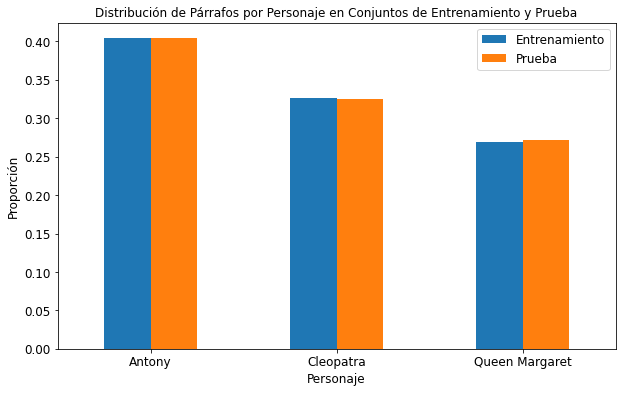

In [8]:
# TODO: Partir train/test 30% estratificados
# -> Definir X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")

train_data = pd.DataFrame({'CleanText': X_train, 'CharName': y_train})
test_data = pd.DataFrame({'CleanText': X_test, 'CharName': y_test})

# Mostrar la distribución de los datos
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(10, 6))

# Crear un DataFrame con las distribuciones
distribution_df = pd.DataFrame({
    'Train': train_distribution,
    'Test': test_distribution
})

# Crear el gráfico de barras
distribution_df.plot(kind='bar', ax=ax)
ax.set_title('Distribución de Párrafos por Personaje en Conjuntos de Entrenamiento y Prueba')
ax.set_xlabel('Personaje',fontsize=12)
ax.set_ylabel('Proporción',fontsize=12)
ax.legend(['Entrenamiento', 'Prueba'],fontsize=12)

# Mostrar el gráfico
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Conteo de palabras y TF-IDF

In [9]:
count_vect = CountVectorizer(stop_words=None, ngram_range=(1,1))
X_train_counts = count_vect.fit_transform(X_train)
X_train_counts
# Crear el objeto CountVectorizer
vectorizer = CountVectorizer()

# Ajustar y transformar los datos de entrenamiento
X_train_counts = vectorizer.fit_transform(train_data["CleanText"])

# Mostrar el tamaño de la matriz resultante
print(f"Tamaño de la matriz resultante: {X_train_counts.shape}")

# Mostrar un ejemplo de los primeros 5 documentos y sus representaciones
print(X_train_counts[:5].toarray())
print(vectorizer.get_feature_names_out()[:50])  # Mostrar las primeras 30 palabras del vocabulario


Tamaño de la matriz resultante: (438, 2807)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names_out'

In [10]:
tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)
X_train_tf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizertfid = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento
X_train_tfidf = vectorizertfid.fit_transform(train_data["CleanText"])
X_test_tfidf = vectorizertfid.transform(test_data["CleanText"])

# Mostrar el tamaño de la matriz resultante
print(f"Tamaño de la matriz TF-IDF resultante: {X_train_tfidf.shape}")

# Mostrar un ejemplo de los primeros 5 documentos y sus representaciones
print(X_train_tfidf[:5].toarray())
print(vectorizertfid.get_feature_names_out()[:30])  # Mostrar las primeras 30 palabras del vocabulario

Tamaño de la matriz TF-IDF resultante: (438, 2807)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names_out'

### Reducción de dimensionalidad

In [11]:
# TODO: Realizar PCA sobre los datos de entrenamiento
# reductor = ...
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_red = pca.fit_transform(X_train_tfidf.toarray())

# Crear un DataFrame con las componentes principales y los nombres de los personajes
train_pca_df = pd.DataFrame(X_train_red, columns=['PCA1', 'PCA2'])
train_pca_df['Character'] = y_train



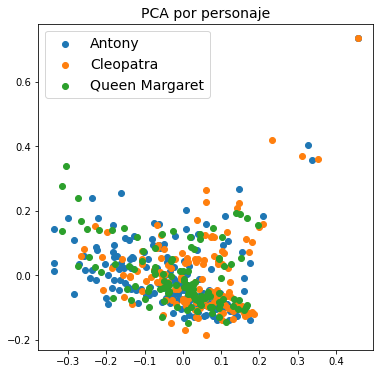

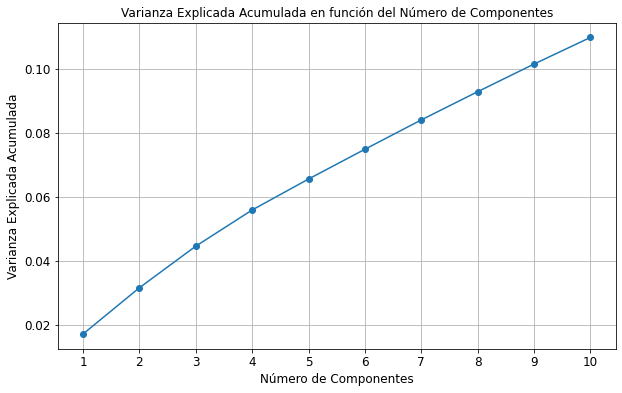

In [12]:
# Visualización de las dos primeras componentes de PCA
fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje", fontsize=14)
ax.legend(fontsize=14)

pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())

# Crear un DataFrame con las componentes principales y los nombres de los personajes
train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PCA{i+1}' for i in range(10)])
train_pca_df['Character'] = y_train

# Calcular la varianza explicada acumulada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Visualizar la varianza explicada acumulada
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), cumulative_variance, marker='o')
plt.title('Varianza Explicada Acumulada en función del Número de Componentes', fontsize=12)
plt.xlabel('Número de Componentes', fontsize=12)
plt.ylabel('Varianza Explicada Acumulada', fontsize=12)
plt.xticks(range(1, 11), fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

## Modelos de Clasificación

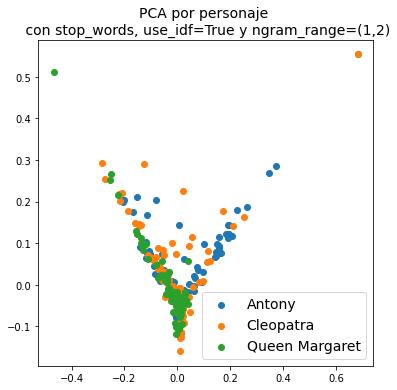

In [13]:

# Vectorización con los nuevos parámetros
vectorizer_new = TfidfVectorizer(stop_words='english', use_idf=True, ngram_range=(1, 2))
X_train_tfidf_new = vectorizer_new.fit_transform(X_train)

# Aplicar PCA con 2 componentes
pca_2_new = PCA(n_components=2)
X_train_red_new = pca_2_new.fit_transform(X_train_tfidf_new.toarray())

# Crear un DataFrame con las componentes principales y los nombres de los personajes
train_pca_df_2_new = pd.DataFrame(X_train_red_new, columns=['PCA1', 'PCA2'])
train_pca_df_2_new['Character'] = y_train

# Visualización de las dos primeras componentes de PCA
fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red_new[mask_train, 0], X_train_red_new[mask_train, 1], label=character)

ax.set_title("PCA por personaje \n con stop_words, use_idf=True y ngram_range=(1,2)",fontsize=14)
ax.legend(fontsize=14)
plt.show()


In [14]:
bayes_clf = MultinomialNB().fit(X_train_tf, y_train)

# Ver las primeras 10 predicciones de train
y_pred_train = bayes_clf.predict(X_train_tf)
y_pred_train[:10]

array(['Antony', 'Antony', 'Antony', 'Antony', 'Cleopatra', 'Antony',
       'Antony', 'Antony', 'Antony', 'Antony'], dtype='<U14')

In [15]:
def get_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum() / len(y_true)

get_accuracy(y_train, y_pred_train)

0.6461187214611872

Accuracy: 0.5
Matriz de Confusión:
[[72  3  1]
 [49 12  0]
 [37  4 10]]


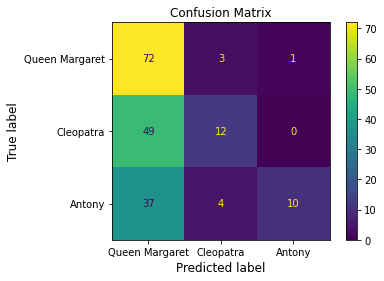

Reporte de Clasificación:
                precision    recall  f1-score   support

Queen Margaret       0.46      0.95      0.62        76
     Cleopatra       0.63      0.20      0.30        61
        Antony       0.91      0.20      0.32        51

      accuracy                           0.50       188
     macro avg       0.67      0.45      0.41       188
  weighted avg       0.64      0.50      0.43       188



In [16]:
# TODO: Predecir para test y ver la matriz de confusión, y reportar accuracy
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# X_test_counts = ...
# X_test_tfidf = ...
# y_test_pred = ...

bayes_clf = MultinomialNB().fit(X_train_tfidf, y_train)
y_pred_test = bayes_clf.predict(X_test_tfidf)

# Calcular accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy: {accuracy}')
char_names =train_pca_df['Character'].unique()

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('Matriz de Confusión:')
print(conf_matrix)

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay con nombres de personajes

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=char_names)
disp.plot()
plt.title('Confusion Matrix',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.ylabel('True label',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Reportar precision y recall para cada personaje
class_report = classification_report(y_test, y_pred_test, target_names=train_pca_df['Character'].unique())
print('Reporte de Clasificación:')
print(class_report)

### Búsqueda de hiper-parámetros con Cross-Validation

Fold Accuracy: 0.6273 for params: {'stop_words': None, 'ngram': (1, 2), 'idf': True, 'alpha': 0.01}
Fold Accuracy: 0.5909 for params: {'stop_words': None, 'ngram': (1, 2), 'idf': True, 'alpha': 0.01}
Fold Accuracy: 0.5413 for params: {'stop_words': None, 'ngram': (1, 2), 'idf': True, 'alpha': 0.01}
Fold Accuracy: 0.5780 for params: {'stop_words': None, 'ngram': (1, 2), 'idf': True, 'alpha': 0.01}
Fold Accuracy: 0.6091 for params: {'stop_words': None, 'ngram': (1, 1), 'idf': False, 'alpha': 0.1}
Fold Accuracy: 0.5909 for params: {'stop_words': None, 'ngram': (1, 1), 'idf': False, 'alpha': 0.1}
Fold Accuracy: 0.6330 for params: {'stop_words': None, 'ngram': (1, 1), 'idf': False, 'alpha': 0.1}
Fold Accuracy: 0.5413 for params: {'stop_words': None, 'ngram': (1, 1), 'idf': False, 'alpha': 0.1}
Fold Accuracy: 0.5455 for params: {'stop_words': 'english', 'ngram': (1, 2), 'idf': True, 'alpha': 1.0}
Fold Accuracy: 0.5727 for params: {'stop_words': 'english', 'ngram': (1, 2), 'idf': True, 'alpha

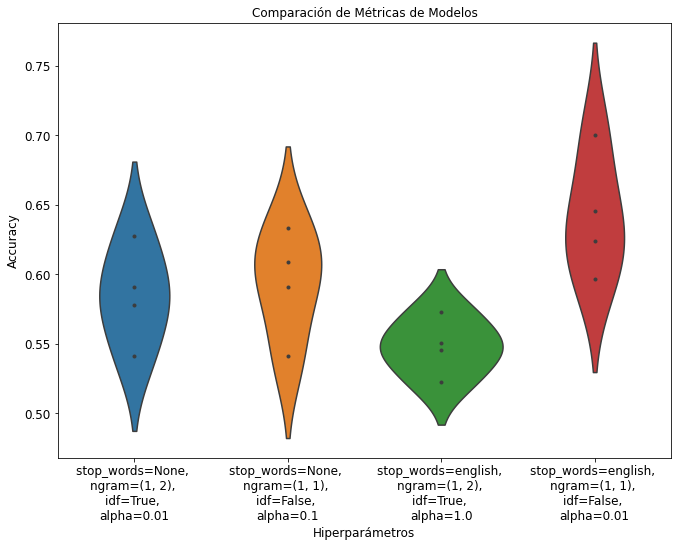

In [17]:
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
X_dev = X_train
y_dev = y_train
# TODO: Agregar más variantes de parámetros que les parezcan relevantes
param_sets = [
    {"stop_words": None, "ngram": (1, 2), "idf": True, "alpha": 0.01},
    {"stop_words": None, "ngram": (1, 1), "idf": False, "alpha": 0.1},
    {"stop_words": 'english', "ngram": (1, 2), "idf": True, "alpha": 1.0},
    {"stop_words": 'english', "ngram": (1, 1), "idf": False, "alpha": 0.01}
]

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

results = []

for params in param_sets:
    # Transformaciones a aplicar (featurizers)
    count_vect = CountVectorizer(stop_words=params["stop_words"], ngram_range=params["ngram"])
    tf_idf = TfidfTransformer(use_idf=params["idf"])
    
    fold_accuracies = []
    
    for train_idxs, val_idxs in skf.split(X_dev, y_dev):
        # Train y validation para el split actual
        X_train_, y_train_ = X_dev[train_idxs], y_dev[train_idxs]
        X_val, y_val = X_dev[val_idxs], y_dev[val_idxs]
        
        # Ajustamos y transformamos Train
        X_train_counts = count_vect.fit_transform(X_train_)
        X_train_tf = tf_idf.fit_transform(X_train_counts)
        
        # Entrenamos con Train
        bayes_clf = MultinomialNB(alpha=params["alpha"])
        bayes_clf.fit(X_train_tf, y_train_)
        
        # Transformamos Validation
        X_val_counts = count_vect.transform(X_val)
        X_val_tfidf = tf_idf.transform(X_val_counts)
        
        # Predecimos y evaluamos en Validation
        y_pred_val = bayes_clf.predict(X_val_tfidf)
        acc = accuracy_score(y_val, y_pred_val)
        fold_accuracies.append(acc)
        
        print(f"Fold Accuracy: {acc:.4f} for params: {params}")
    
    # Guardar resultados de accuracy para los diferentes splits
    for fold_accuracy in fold_accuracies:
        results.append({
            "params": params,
            "accuracy": fold_accuracy
        })

# Crear DataFrame con los resultados
results_df = pd.DataFrame(results)

# Agregar una columna de parámetros como cadena
results_df['params_str'] = results_df['params'].apply(lambda x: f"stop_words={x['stop_words']}, \nngram={x['ngram']}, \nidf={x['idf']}, \nalpha={x['alpha']}")

# Visualización de los resultados utilizando un gráfico de violín
plt.figure(figsize=(11, 8))
sns.violinplot(x='params_str', y='accuracy', data=results_df, inner='point')
plt.xticks(rotation=0,fontsize=12)
plt.yticks(fontsize=12)
plt.title('Comparación de Métricas de Modelos',fontsize=12)
plt.xlabel('Hiperparámetros',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.show()

Accuracy: 0.6329787234042553


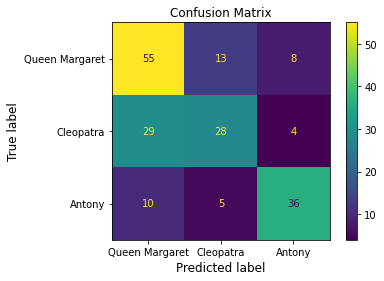

                precision    recall  f1-score   support

Queen Margaret       0.59      0.72      0.65        76
     Cleopatra       0.61      0.46      0.52        61
        Antony       0.75      0.71      0.73        51

      accuracy                           0.63       188
     macro avg       0.65      0.63      0.63       188
  weighted avg       0.64      0.63      0.63       188



In [18]:
best_params = {'stop_words': 'english', 'ngram': (1, 1), 'idf': False, 'alpha': 0.01}
# Transformaciones a aplicar (featurizers)
count_vect = CountVectorizer(stop_words=best_params['stop_words'], ngram_range=best_params['ngram'])
tf_idf = TfidfTransformer(use_idf=best_params['idf'])

# Ajustamos y transformamos Train
X_train_counts = count_vect.fit_transform(X_train)
X_train_tf = tf_idf.fit_transform(X_train_counts)

# Entrenamos con Train
bayes_clf = MultinomialNB(alpha=best_params['alpha'])
bayes_clf.fit(X_train_tf, y_train)

# Transformamos Test
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tf_idf.transform(X_test_counts)

# Predecimos y evaluamos en Test
y_pred_test = bayes_clf.predict(X_test_tfidf)

# Calcular el valor de accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy}")

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Mapeo de IDs a nombres de personajes
id_to_charname = dict(zip(df_characters['id'], df_characters['CharName']))
char_names =train_pca_df['Character'].unique()

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay con nombres de personajes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=char_names)
disp.plot()
plt.title('Confusion Matrix',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.ylabel('True label',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Reportar el valor de precision y recall para cada clase
report = classification_report(y_test, y_pred_test, target_names=train_pca_df['Character'].unique())
print(report)

Accuracy SVM: 0.6223404255319149


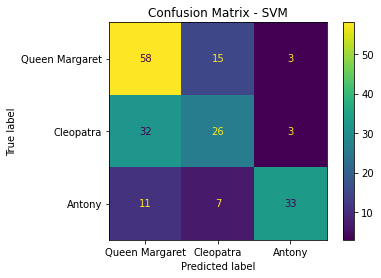

                precision    recall  f1-score   support

Queen Margaret       0.57      0.76      0.66        76
     Cleopatra       0.54      0.43      0.48        61
        Antony       0.85      0.65      0.73        51

      accuracy                           0.62       188
     macro avg       0.65      0.61      0.62       188
  weighted avg       0.64      0.62      0.62       188



In [19]:
from sklearn.svm import SVC
# Transformaciones a aplicar (featurizers)
count_vect = CountVectorizer(stop_words=best_params['stop_words'], ngram_range=best_params['ngram'])
tf_idf = TfidfTransformer(use_idf=best_params['idf'])

# Ajustamos y transformamos Train
X_train_counts = count_vect.fit_transform(X_train)
X_train_tf = tf_idf.fit_transform(X_train_counts)

# Entrenamos con Train usando SVM
svm_clf = SVC(kernel='linear', C=1)
svm_clf.fit(X_train_tf, y_train)

# Transformamos Test
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tf_idf.transform(X_test_counts)

# Predecimos y evaluamos en Test usando SVM
y_pred_test_svm = svm_clf.predict(X_test_tfidf)

# Calcular el valor de accuracy
accuracy_svm = accuracy_score(y_test, y_pred_test_svm)
print(f"Accuracy SVM: {accuracy_svm}")

# Generar la matriz de confusión
conf_matrix_svm = confusion_matrix(y_test, y_pred_test_svm)

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay con nombres de personajes
disp_svm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=char_names)
disp_svm.plot()
plt.title('Confusion Matrix - SVM')
plt.show()

# Reportar el valor de precision y recall para cada clase
report_svm = classification_report(y_test, y_pred_test_svm, target_names=char_names)
print(report_svm)

Tamaños de Train/Test: 525/225
Henry V           264
Cleopatra         143
Queen Margaret    118
dtype: int64
Henry V           113
Cleopatra          61
Queen Margaret     51
dtype: int64
Accuracy: 0.5066666666666667
Matriz de Confusión:
[[  1  60   0]
 [  0 113   0]
 [  0  51   0]]


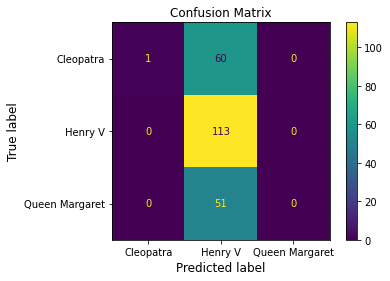

Reporte de Clasificación:
                precision    recall  f1-score   support

     Cleopatra       1.00      0.02      0.03        61
       Henry V       0.50      1.00      0.67       113
Queen Margaret       0.00      0.00      0.00        51

      accuracy                           0.51       225
     macro avg       0.50      0.34      0.23       225
  weighted avg       0.52      0.51      0.35       225



C:\Users\sofiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sofiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sofiag\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Agregamos personajes, obras y géneros en el mismo dataset
df_dataset = df_paragraphs.merge(df_chapters.set_index("id")["work_id"], left_on="chapter_id", right_index=True)
df_dataset = df_dataset.merge(df_works.set_index("id")[["Title", "GenreType"]], left_on="work_id", right_index=True)
df_dataset = df_dataset.merge(df_characters.set_index('id')["CharName"], left_on="character_id", right_index=True).sort_index()
df_dataset = df_dataset[["CleanText", "CharName", "Title", "GenreType"]]

# Usaremos sólo estos personajes
characters = ["Henry V", "Cleopatra", "Queen Margaret"]
df_dataset = df_dataset[df_dataset["CharName"].isin(characters)]


# Párrafos por cada personaje seleccionado
df_dataset["CharName"].value_counts()

X = df_dataset["CleanText"].to_numpy()
y = df_dataset["CharName"].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

print(f"Tamaños de Train/Test: {len(X_train)}/{len(X_test)}")
print(pd.Series(y_train).value_counts())
print(pd.Series(y_test).value_counts())

vectorizertfid = TfidfVectorizer(stop_words=None, ngram_range=(1, 1))

# Ajustar y transformar los datos de entrenamiento
X_train_tfidf = vectorizertfid.fit_transform(X_train)
X_test_tfidf = vectorizertfid.transform(X_test)

# Entrenar el modelo
bayes_clf = MultinomialNB().fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred_test = bayes_clf.predict(X_test_tfidf)

# Calcular accuracy
accuracy = accuracy_score(y_test, y_pred_test)
print(f'Accuracy: {accuracy}')

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_test)
print('Matriz de Confusión:')
print(conf_matrix)

# Mostrar la matriz de confusión utilizando ConfusionMatrixDisplay con nombres de personajes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=bayes_clf.classes_)
disp.plot()
plt.title('Confusion Matrix',fontsize=12)
plt.xlabel('Predicted label',fontsize=12)
plt.ylabel('True label',fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

# Reportar precision y recall para cada personaje
class_report = classification_report(y_test, y_pred_test, target_names=bayes_clf.classes_)
print('Reporte de Clasificación:')
print(class_report)


In [21]:
tf_idf = TfidfTransformer(use_idf=False)
X_train_tf = tf_idf.fit_transform(X_train_counts)
X_train_tf
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizertfid = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento
X_train_tfidf = vectorizertfid.fit_transform(train_data["CleanText"])
X_test_tfidf = vectorizertfid.transform(test_data["CleanText"])

# Mostrar el tamaño de la matriz resultante
print(f"Tamaño de la matriz TF-IDF resultante: {X_train_tfidf.shape}")

# Mostrar un ejemplo de los primeros 5 documentos y sus representaciones
print(X_train_tfidf[:5].toarray())
print(vectorizertfid.get_feature_names_out()[:30])  # Mostrar las primeras 30 palabras del vocabulario

pca = PCA(n_components=2)
X_train_red = pca.fit_transform(X_train_tfidf.toarray())

# Crear un DataFrame con las componentes principales y los nombres de los personajes
train_pca_df = pd.DataFrame(X_train_red, columns=['PCA1', 'PCA2'])
train_pca_df['Character'] = y_train

# Visualización de las dos primeras componentes de PCA
fig, ax = plt.subplots(figsize=(6, 6))
for character in np.unique(y_train):
    mask_train = y_train == character
    ax.scatter(X_train_red[mask_train, 0], X_train_red[mask_train, 1], label=character)

ax.set_title("PCA por personaje")
ax.legend()



Tamaño de la matriz TF-IDF resultante: (438, 2807)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names_out'

### (Opcional) Comparativa con Fasttext

In [23]:
!pip install fasttext

ERROR: Could not find a version that satisfies the requirement fasttext
ERROR: No matching distribution found for fasttext


In [22]:
import fasttext

y_train_s = np.char.replace(y_train.astype(str), " ", "_").astype(object)
y_test_s = np.char.replace(y_test.astype(str), " ", "_").astype(object)

# Convertimos al formato de fasttext: archivo de texto donde cada línea es:
# __label__<label> TEXTO
Xytrains = "__label__" + y_train_s.astype(object) + " " + X_train
Xytests = "__label__" + y_test_s.astype(object) + " " + X_test
np.savetxt(data_dir / "train.txt", Xytrains, fmt="%s")
np.savetxt(data_dir / "test.txt", Xytests, fmt="%s")

Xytests[0]

ModuleNotFoundError: No module named 'fasttext'

In [ ]:
model = fasttext.train_supervised(input=str(data_dir / "train.txt"), epoch=100, wordNgrams=2)
model.test(str(data_dir / "test.txt"))

In [ ]:
y_out = model.predict(list(X_test))
y_pred_test = [y[0].replace("__label__", "") for y in y_out[0]]
    
print(get_accuracy(y_test_s, y_pred_test))